In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.fftpack import fft
from numpy.fft import fftfreq
from scipy import integrate

import time

import numba
from numba import jit, njit, generated_jit, vectorize, guvectorize, float64

import mpi4py

In [0]:
envelope_type = 'gauss'

In [0]:
'''
This cell exploits analytical calculation of trajectories (u and x) of electron 
motion in laboratory frame
'''

#@jit(nopython=True)
def g(eta, tau, fl=envelope_type):
    if fl == 'gauss':
        res = np.exp(-eta**2/tau**2)
    elif fl == 'super gauss':
        res = np.exp(-eta**60/tau**60)
    elif fl == 'sin':
        n = np.shape(eta)[0]
        res = np.zeros(n)
        ind = np.where((eta > 0) & (eta < tau))
        res[ind] = (np.sin(np.pi * eta[ind] / tau))**2
        
    return res

#@njit
def A_(eta, a0, delta, tau):
    n = np.shape(eta)[0]
    A = np.zeros((n,3))
    A[:,0] = a0 * g(eta, tau) * np.cos(eta)
    A[:,1] = a0 * g(eta, tau) * delta * np.sin(eta)
    
    return A

#@njit
def u_(eta, a0, delta, tau, u0, gamma0):
    n = np.shape(eta)[0]
    u = np.zeros((n,3))
    A = A_(eta, a0, delta, tau)

    pi0 = gamma0 - u0[2]

    u[:,0] = u0[0] + A[:,0]
    u[:,1] = u0[1] + A[:,1]
    u[:,2] = u0[2] + (u0[0] * A[:,0] + u0[1] * A[:,1] + 0.5 * (A[:,0]**2 + A[:,1]**2)) / pi0

    return u

#@jit
def create_dynamics(eta, a0, delta, tau, d_eta, u0=np.zeros(3), gamma0=1, x0=np.zeros(3)):
    n = np.shape(eta)[0]
    u_r = np.zeros((n,7))
    u_r[:,0] = eta.copy()
    
    u_r[:,1:4] = u_(eta, a0, delta, tau, u0, gamma0)

    pi0 = gamma0 - u0[2]
    
    u_r[:,4] = x0[0] + integrate.cumtrapz(u_r[:,1]/pi0, dx=d_eta, initial=0)
    u_r[:,5] = x0[1] + integrate.cumtrapz(u_r[:,2]/pi0, dx=d_eta, initial=0)
    u_r[:,6] = x0[2] + integrate.cumtrapz(u_r[:,3]/pi0, dx=d_eta, initial=0)
    
    return u_r

In [0]:
#@title Trajectories in Lab frame
a0 = 3
delta = 0

#pulse parameters
tau = 5 * 2 * np.pi      #length of a pulse
eta_end = 150             #boundary of simulation grid in \eta
n_eta = 2*eta_end*200     #number of points in \eta grid
d_eta = 2*eta_end/n_eta   
eta = np.linspace(-eta_end, eta_end, n_eta)  #\eta grid

v0 = np.array([.05,.03,-0.8])
gamma0 = 1. / np.sqrt(1 - v0[0]**2 - v0[1]**2 - v0[2]**2)
u0 = v0 * gamma0

x0 = np.array([0,0,0])


start = time.time()
A = A_(eta, a0, delta, tau)
u_r = create_dynamics(eta, a0, delta, tau, d_eta, u0=u0, gamma0=gamma0, x0=x0)
end = time.time() - start
print('First run: ', end)

start = time.time()
A = A_(eta, a0, delta, tau)
u_r = create_dynamics(eta, a0, delta, tau, d_eta, u0=u0, gamma0=gamma0, x0=x0)
end = time.time() - start
print('Second run: ', end)

First run:  0.01644730567932129
Second run:  0.012812137603759766


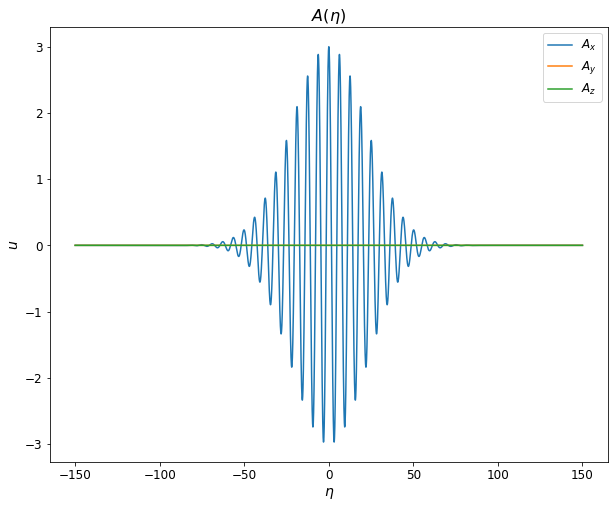

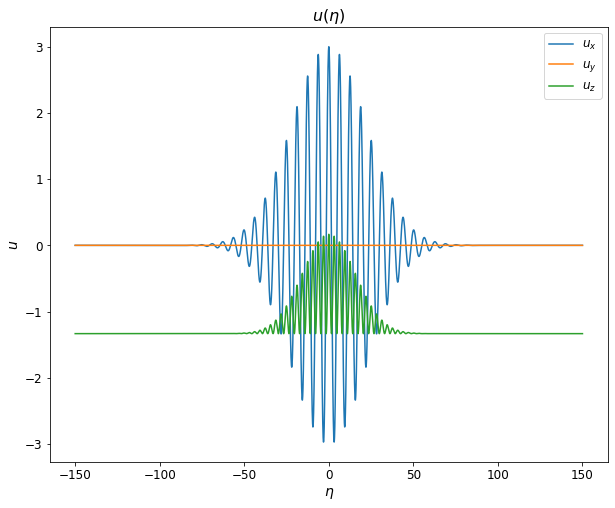

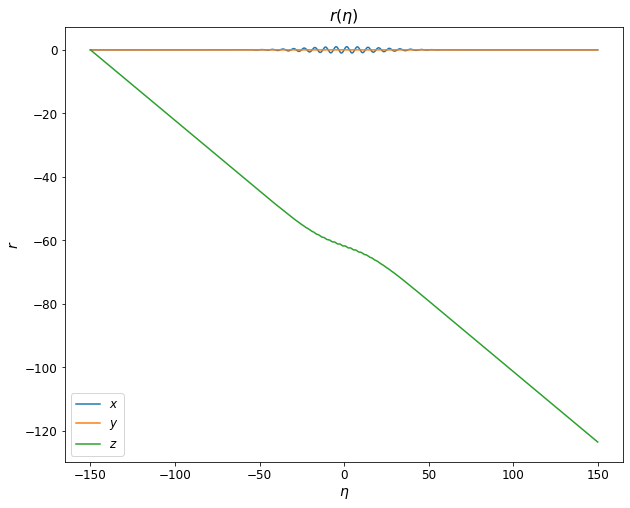

In [0]:
#@title Graphs

plt.figure(figsize=(10,8))
plt.plot(eta, A[:,0], label='$A_x$')
plt.plot(eta, A[:,1], label='$A_y$')
plt.plot(eta, A[:,2], label='$A_z$')
plt.xlabel('$\eta$', fontsize=14)
plt.ylabel('$u$', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.title('$A(\eta)$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(eta, u_r[:,1], label='$u_x$')
plt.plot(eta, u_r[:,2], label='$u_y$')
plt.plot(eta, u_r[:,3], label='$u_z$')
plt.xlabel('$\eta$', fontsize=14)
plt.ylabel('$u$', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.title('$u(\eta)$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(eta, u_r[:,4], label='$x$')
plt.plot(eta, u_r[:,5], label='$y$')
plt.plot(eta, u_r[:,6], label='$z$')
plt.xlabel('$\eta$', fontsize=14)
plt.ylabel('$r$', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.title('$r(\eta)$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [0]:
#@title FFT
#@jit
def ft(samples, Fs, t0):
    """Approximate the Fourier Transform of a time-limited 
    signal by means of the discrete Fourier Transform.
    
    samples: signal values sampled at the positions t0 + n/Fs
    Fs: Sampling frequency of the signal
    t0: starting time of the sampling of the signal
    """
    f = np.linspace(-Fs/2, Fs/2, len(samples), endpoint=False)
    return np.fft.fftshift(np.fft.fft(samples)/Fs * np.exp(2j*np.pi*f*t0))

In [0]:
#@title Spectrum for 1 electron
def spec_I_w(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded, u0, 
             gamma0, x0, theta=np.pi, fi=0, t_end=0):
    
    #calculating trajectories
    u_r = create_dynamics(eta, a0, delta, tau, d_eta, u0=u0, gamma0=gamma0, x0=x0)

    pi0 = gamma0 - u0[2]

    u_x_points = u_r[:,1]
    u_y_points = u_r[:,2]
    u_z_points = u_r[:,3]
    
    x_points = u_r[:,4]
    y_points = u_r[:,5]
    z_points = u_r[:,6]
    
    #new time corresponding to \eta and construction of adaptive grid in t
    t_eta_points = eta + (1 - np.cos(theta))*z_points - x_points * np.cos(fi) * np.sin(theta) - y_points * np.sin(fi) * np.sin(theta)
    
    #if t_end == 0:
    t_end = max(t_eta_points)
    t = np.linspace(-t0, t_end, n_t_points)
    
    #interpolation of \eta(t)
    eta_interp = interp1d(t_eta_points, eta, kind='cubic')
    
    #interpolation of trajectories
    u_x = interp1d(eta, u_x_points, kind='cubic')
    u_y = interp1d(eta, u_y_points, kind='cubic')
    u_z = interp1d(eta, u_z_points, kind='cubic')
    
    x = interp1d(eta, x_points, kind='cubic')
    y = interp1d(eta, y_points, kind='cubic')
    z = interp1d(eta, z_points, kind='cubic')
    
    #integrand in retarded time
    u_x_ret = u_x(eta_interp(t))
    u_y_ret = u_y(eta_interp(t))
    u_z_ret = u_z(eta_interp(t))
    
    #Jacobian of time transform in retarded time
    Jacobian_ret = 1 + ((1 - np.cos(theta))*u_z_ret - u_x_ret*np.cos(fi)*np.sin(theta) - u_y_ret*np.sin(fi)*np.sin(theta)) / pi0 
    
    #Samples of Ix integrals on t grid
    Ix_samples = u_x_ret / Jacobian_ret / pi0
    Iy_samples = u_y_ret / Jacobian_ret / pi0
    Iz_samples = u_z_ret / Jacobian_ret / pi0
    
    #padding with zeros
    Ix_samples = np.pad(Ix_samples, n_t_padded, 'constant')
    Iy_samples = np.pad(Iy_samples, n_t_padded, 'constant')
    Iz_samples = np.pad(Iz_samples, n_t_padded, 'constant')
    
    #sampling frequency and frequency range
    Fs = n_t_points / (t0+t_end)
    f = np.linspace(-Fs/2, Fs/2, len(Ix_samples), endpoint=False)
    
    #new start time of sampling
    t0_new = t0 + n_t_padded/Fs
    
    #fft for positive frequncies
    Ix = ft(Ix_samples, Fs, t0_new)[f>=0]
    Iy = ft(Iy_samples, Fs, t0_new)[f>=0]
    Iz = ft(Iz_samples, Fs, t0_new)[f>=0]   
    
    #components of intensity
    I_theta = Ix * np.cos(theta) * np.cos(fi) + Iy * np.cos(theta) * np.sin(fi) - Iz * np.sin(theta)
    I_fi = Ix * np.sin(fi) - Iy * np.cos(fi)
    
    #overall intensity
    f = f[f>=0]
    I = f**2 * (np.abs(I_theta)**2 + np.abs(I_fi)**2)
    
    return I, f, eta_interp, t

In [0]:
#@title Spectrum for many electrons
def spec_I_w_many(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded, u0, 
                  gamma0, x0, theta=np.pi, fi=0, t_end=0):
    
    n_electrons = u0.shape[0]
    #n_w = (w_end - w_start) * 1000

    #w = np.linspace(w_start, w_end, n_w)

    #I_theta_tot = np.zeros(n_w)
    #I_fi_tot = np.zeros(n_w)

    I = [None] * n_electrons
    w = [None] * n_electrons

    for i in range(n_electrons):

        #calculating trajectories
        u_r = create_dynamics(eta, a0, delta, tau, d_eta, 
                              u0=u0[i,:], gamma0=gamma0[i,0], x0=x0[i,:])

        pi0 = gamma0[i,0] - u0[i,2]

        u_x_points = u_r[:,1]
        u_y_points = u_r[:,2]
        u_z_points = u_r[:,3]
        
        x_points = u_r[:,4]
        y_points = u_r[:,5]
        z_points = u_r[:,6]
        
        #new time corresponding to \eta and construction of adaptive grid in t
        t_eta_points = eta + (1 - np.cos(theta))*z_points - x_points * np.cos(fi) * np.sin(theta) - y_points * np.sin(fi) * np.sin(theta)
        
        #if t_end == 0:f = f[f>=0]
        t_end = max(t_eta_points)
        t = np.linspace(-t0, t_end, n_t_points)
        
        #interpolation of \eta(t)
        eta_interp = interp1d(t_eta_points, eta, kind='cubic')
        
        #interpolation of trajectories
        u_x = interp1d(eta, u_x_points, kind='cubic')
        u_y = interp1d(eta, u_y_points, kind='cubic')
        u_z = interp1d(eta, u_z_points, kind='cubic')
        
        x = interp1d(eta, x_points, kind='cubic')
        y = interp1d(eta, y_points, kind='cubic')
        z = interp1d(eta, z_points, kind='cubic')
        
        #integrand in retarded time
        u_x_ret = u_x(eta_interp(t))
        u_y_ret = u_y(eta_interp(t))
        u_z_ret = u_z(eta_interp(t))
        
        #Jacobian of time transform in retarded time
        Jacobian_ret = 1 + ((1 - np.cos(theta))*u_z_ret - u_x_ret*np.cos(fi)*np.sin(theta) - u_y_ret*np.sin(fi)*np.sin(theta)) / pi0 
        
        #Samples of Ix integrals on t grid
        Ix_samples = u_x_ret / Jacobian_ret / pi0
        Iy_samples = u_y_ret / Jacobian_ret / pi0
        Iz_samples = u_z_ret / Jacobian_ret / pi0
        
        #padding with zeros
        Ix_samples = np.pad(Ix_samples, n_t_padded, 'constant')
        Iy_samples = np.pad(Iy_samples, n_t_padded, 'constant')
        Iz_samples = np.pad(Iz_samples, n_t_padded, 'constant')
        
        #sampling frequency and frequency range
        Fs = n_t_points / (t0+t_end)
        f = np.linspace(-Fs/2, Fs/2, len(Ix_samples), endpoint=False)
        
        #new start time of sampling
        t0_new = t0 + n_t_padded/Fs
        
        #fft for positive frequncies
        Ix = ft(Ix_samples, Fs, t0_new)[f>=0]
        Iy = ft(Iy_samples, Fs, t0_new)[f>=0]
        Iz = ft(Iz_samples, Fs, t0_new)[f>=0]   
        
        #components of intensity
        # I_theta = Ix * np.cos(theta) * np.cos(fi) + Iy * np.cos(theta) * np.sin(fi) - Iz * np.sin(theta)
        # I_fi = Ix * np.sin(fi) - Iy * np.cos(fi)

        w[i] = 2 * np.pi * f[f>=0]

        I[i] = [Ix, Iy, Iz]

        # w = 2 * np.pi * f
        # idx = (w > w_start_interp) & (w < w_end_interp)
        # w_points = w[idx]
        
        # I_theta_points = I_theta[idx]
        # I_fi_points = I_fi[idx]

        # I_theta_interp = interp1d(w_points, I_theta_points, kind='cubic')
        # I_fi_interp = interp1d(w_points, I_fi_points, kind='cubic')

        # I_theta_tot = I_theta_tot + I_theta_interp(w)
        # I_fi_tot = I_fi_tot + I_fi_interp(w)

    
    #overall intensity
    #I = w**2 * (np.abs(I_theta_tot)**2 + np.abs(I_fi_tot)**2)
    
    return I, w

In [0]:
#@title Sum individual spectrums to one
def I_sum(w, I, w_start, w_end, n_w, w_start_interp=0, w_end_interp=100):
    n_electrons = len(w)

    w_f = np.linspace(w_start, w_end, n_w)
    I_f = np.zeros((3,n_w), dtype=np.complex)

    for i in range(n_electrons):
        idx = (w[i] > w_start_interp) & (w[i] < w_end_interp)
        w_points = w[i][idx]

        Ix_points = I[i][0][idx]
        Iy_points = I[i][1][idx]
        Iz_points = I[i][2][idx]

        Ix = interp1d(w_points, Ix_points, kind='cubic')
        Iy = interp1d(w_points, Iy_points, kind='cubic')
        Iz = interp1d(w_points, Iz_points, kind='cubic')

        I_f[0,:] = I_f[0,:] + Ix(w_f)
        I_f[1,:] = I_f[1,:] + Iy(w_f)
        I_f[2,:] = I_f[2,:] + Iz(w_f)

    I_theta = I_f[0,:] * np.cos(theta) * np.cos(fi) + I_f[1,:] * np.cos(theta) * np.sin(fi) - I_f[2,:] * np.sin(theta)
    I_fi = I_f[0,:] * np.sin(fi) - I_f[1,:] * np.cos(fi)


    I = w_f**2 * (np.abs(I_theta)**2 + np.abs(I_fi)**2)

    return I, w_f

In [0]:
def I_sum_from_file(Iw, w_start, w_end, n_w, w_start_interp=0, w_end_interp=100):
    n_electrons = len(Iw)

    w_f = np.linspace(w_start, w_end, n_w)
    I_f = np.zeros((3,n_w), dtype=np.complex)

    for i in range(n_electrons):
        w = np.array(Iw[i][0], dtype=np.float64)
        idx = (w > w_start_interp) & (w < w_end_interp)
        w_points = w[idx]

        Ix_points = Iw[i][1,idx]
        Iy_points = Iw[i][2,idx]
        Iz_points = Iw[i][3,idx]

        Ix = interp1d(w_points, Ix_points, kind='cubic')
        Iy = interp1d(w_points, Iy_points, kind='cubic')
        Iz = interp1d(w_points, Iz_points, kind='cubic')

        I_f[0,:] = I_f[0,:] + Ix(w_f)
        I_f[1,:] = I_f[1,:] + Iy(w_f)
        I_f[2,:] = I_f[2,:] + Iz(w_f)

    I_theta = I_f[0,:] * np.cos(theta) * np.cos(fi) + I_f[1,:] * np.cos(theta) * np.sin(fi) - I_f[2,:] * np.sin(theta)
    I_fi = I_f[0,:] * np.sin(fi) - I_f[1,:] * np.cos(fi)


    I = w_f**2 * (np.abs(I_theta)**2 + np.abs(I_fi)**2)

    return I, w_f

In [0]:
#@title Separate spectrum

def I_separate(w, I, w_start, w_end, n_w, w_start_interp=0, w_end_interp=100):
    n_electrons = len(w)

    w_f = np.linspace(w_start, w_end, n_w)
    I_f = np.zeros((3,n_w), dtype=np.complex)

    I_sep = [None] * n_electrons

    for i in range(n_electrons):
        idx = (w[i] > w_start_interp) & (w[i] < w_end_interp)
        w_points = w[i][idx]

        Ix_points = I[i][0][idx]
        Iy_points = I[i][1][idx]
        Iz_points = I[i][2][idx]

        Ix = interp1d(w_points, Ix_points, kind='cubic')
        Iy = interp1d(w_points, Iy_points, kind='cubic')
        Iz = interp1d(w_points, Iz_points, kind='cubic')

        # I_f[0,:] = I_f[0,:] + Ix(w_f)
        # I_f[1,:] = I_f[1,:] + Iy(w_f)
        # I_f[2,:] = I_f[2,:] + Iz(w_f)
        Ix_ = Ix(w_f)
        Iy_ = Iy(w_f)
        Iz_ = Iz(w_f)

        I_theta = Ix_ * np.cos(theta) * np.cos(fi) + Iy_* np.cos(theta) * np.sin(fi) - Iz_ * np.sin(theta)
        I_fi = Ix_ * np.sin(fi) - Iy_ * np.cos(fi)


        I_sep[i] = w_f**2 * (np.abs(I_theta)**2 + np.abs(I_fi)**2)

    return I_sep, w_f

In [0]:
#@title Spec old 2D
#spectrum omega/theta

def spec_I_w_theta(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded, n_theta, ind, theta_start=0.,
                   fi=0):
    theta_ = np.linspace(theta_start, np.pi, n_theta)
    m = np.sum(ind)
    I_2D = np.zeros((n_theta,m))
    I_interp_list = []
    
    I, f, interp, t = spec_I_w(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded,
                                       theta=np.pi, fi=fi)
    f_main = f[ind]
    
    for i,theta in enumerate(theta_):
        I, f, interp, t = spec_I_w(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded,
                                   theta=theta, fi=fi)
        I_interp = interp1d(f, I)
        I_interp_list.append(I_interp)
        I_2D[i,:] = I_interp(f_main)
    
    return I_2D/np.max(I_2D), 2*np.pi*f_main, theta_, I_interp_list

In [0]:
#@title Plotter
#plotter function: x_, y_, labels should be lists
def plotter(x_, y_, title, x_label, y_label, labels, figsize=(10,8), fl='plot'):
    
    plt.figure(figsize=figsize)
    
    if len(x_) == 1:
        for y,label in zip(y_,labels):
            plt.plot(x_[0], y, label=label)
    else:
        for x,y,label in zip(x_,y_,labels):
            plt.plot(x, y, label=label)
    
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc='best', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

## Simulation

In [0]:
#simulation parameters

a0 = 1
delta = 0

theta = np.pi
fi = 0

v0 = np.array([0.05,0,-0.9])
gamma0 = 1. / np.sqrt(1 - v0[0]**2 - v0[1]**2 - v0[2]**2)
u0 = v0 * gamma0
print('gamma = %.4f' %gamma0)

x0 = np.zeros(3)

#pulse parameters
tau = 5 * 2 * np.pi      #length of a pulse
eta_end = 150             #boundary of simulation grid in \eta
n_eta = 2*eta_end*1000     #number of points in \eta grid
d_eta = 2*eta_end/n_eta   
eta = np.linspace(-eta_end, eta_end, n_eta)  #\eta grid

#parameters for grid in self-time
t0 = eta_end
n_t_points = t0*1000         #number of points in t grid
n_t_padded = 20*n_t_points  #padded length

gamma = 2.3094


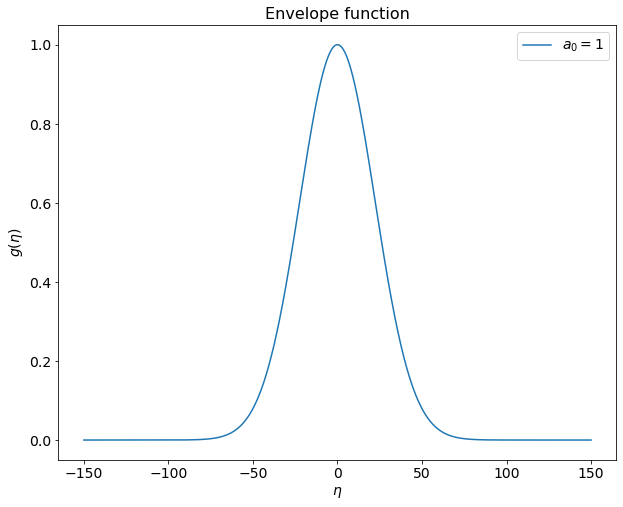

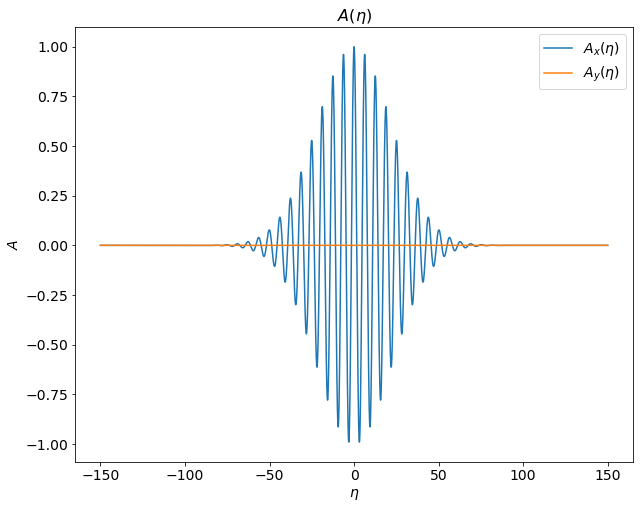

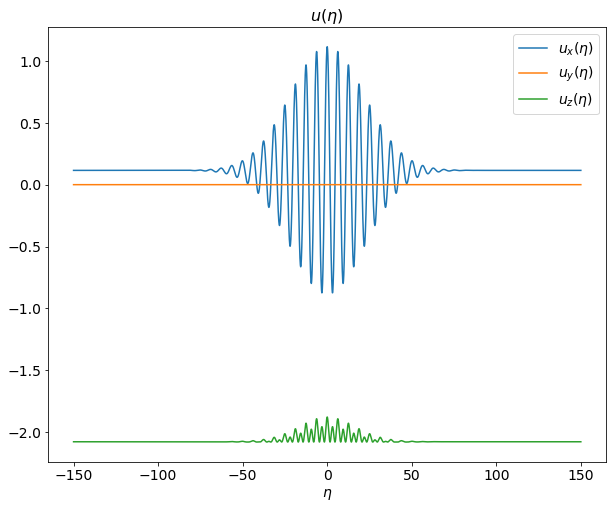

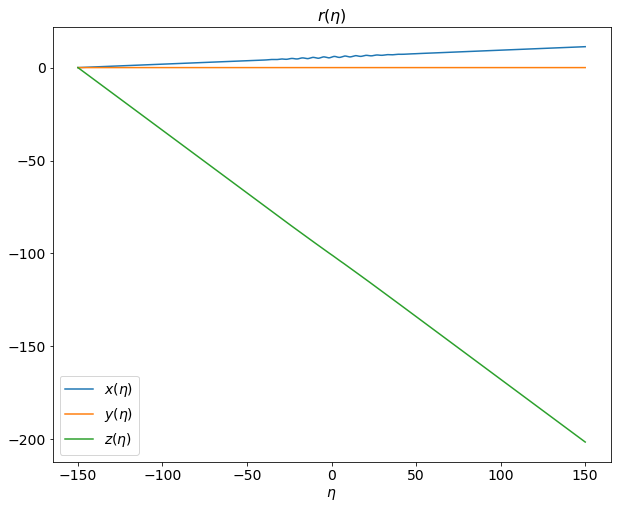

In [0]:
#plots for envelope function, vector potential, velocities and coordinates

plotter([eta], [g(eta,tau)], 'Envelope function', '$\eta$', '$g(\eta)$', ['$a_0=%d$' %a0])

A = A_(eta, a0, delta, tau)
plotter([eta], [A[:,0],A[:,1]], '$A(\eta)$', '$\eta$', '$A$', ['$A_x(\eta)$', '$A_y(\eta)$'])
u_r = create_dynamics(eta, a0, delta, tau, d_eta, u0=u0, x0=x0)
plotter([eta], [u_r[:,1],u_r[:,2],u_r[:,3]], '$u(\eta)$', '$\eta$', '', 
        ['$u_x(\eta)$', '$u_y(\eta)$', '$u_z(\eta)$'])
plotter([eta], [u_r[:,4],u_r[:,5],u_r[:,6]], '$r(\eta)$', '$\eta$', '', 
        ['$x(\eta)$', '$y(\eta)$', '$z(\eta)$'])

In [0]:
#calculation of spectrum
start = time.time()
I, f, interp, t = spec_I_w(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded, u0, gamma0, x0)
end = time.time() - start
print('First run: ', end)

start = time.time()
I, f, interp, t = spec_I_w(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded, u0, gamma0, x0)
end = time.time() - start
print('Second run: ', end)

First run:  3.63541841506958
Second run:  3.356767416000366


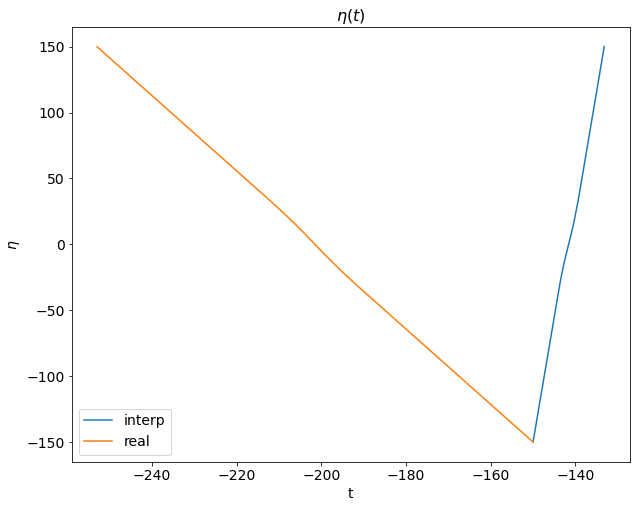

-133.18705747196242


In [0]:
#plot for \eta and t
t_new = u_r[:,0] + 2*u_r[:,6]
plotter([t,t_new], [interp(t),u_r[:,0]], '$\eta(t)$', 't', '$\eta$', ['interp', 'real'])
print(max(t))

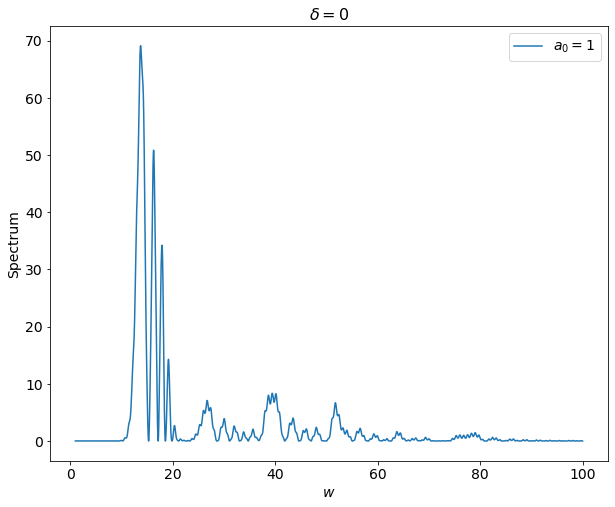

In [0]:
#transition from ordinary frequency to angular
w_num = 2*np.pi*f
w_start = 1
w_end = 100
ind = (w_num >= w_start) & (w_num <= w_end)

plotter([w_num[ind]], [I[ind]], '$\delta = %d$' %delta, '$w$', 
        'Spectrum', ['$a_0=%d$' %a0])

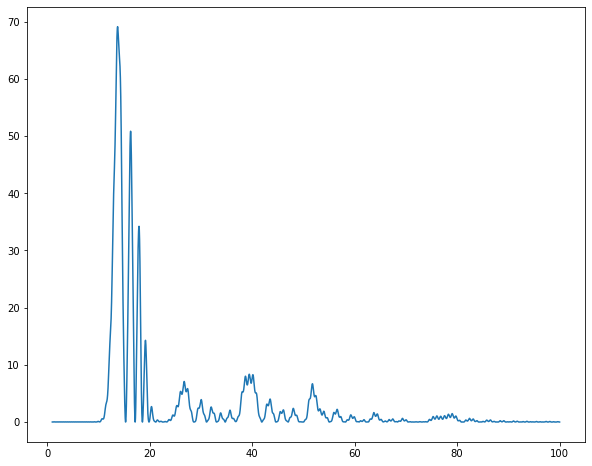

In [0]:
w_start = 1
w_end = 100
idx = (w_num < w_end) & (w_num > w_start)

plt.figure(figsize=(10,8))
plt.plot(w_num[idx], I[idx])
#plt.xscale('log')
plt.show()

## Several electrons

In [0]:
#simulation parameters

a0 = 1
delta = 0

theta = np.pi
fi = 0

#electrons' initial parameters
n_electrons = 4

v0 = np.array([[.0,.0,-0.80],
               [.0,.0,-0.82],
               [.0,.0,-0.85],
               [.0,.0,-0.78]])

gamma0 = 1. / np.sqrt(1. - np.linalg.norm(v0, axis=1))
gamma0 = gamma0.reshape((n_electrons,1))
u0 = v0 * gamma0
print(gamma0)

x0 = np.array([[.0,.0,.0],
               [.0,.0,.0],
               [.0,.0,.0],
               [.0,.0,.0]])

#pulse parameters
tau = 5 * 2 * np.pi      #length of a pulse
eta_end = 150             #boundary of simulation grid in \eta
n_eta = 2*eta_end*2000     #number of points in \eta grid
d_eta = 2*eta_end/n_eta   
eta = np.linspace(-eta_end, eta_end, n_eta)  #\eta grid

#parameters for grid in self-time
t0 = eta_end
n_t_points = t0*100         #number of points in t grid
n_t_padded = 20*n_t_points  #padded length

[[2.23606798]
 [2.3570226 ]
 [2.5819889 ]
 [2.13200716]]


In [0]:
!mpirun -n 4 python3 spec.py

In [0]:
Iw = [None] * n_electrons

for i in range(n_electrons):
    Iw[i] = np.loadtxt('Iw_%d' %i, dtype=complex)

print(np.shape(Iw[0]))

(4, 307500)


In [0]:
w_start_interp = 0
w_end_interp = 100

w_start = 1
w_end = 50

n_w = (w_end - w_start) * 2000

I, w = I_sum_from_file(Iw, w_start, w_end, n_w, w_start_interp, w_end_interp)

/home/maximus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


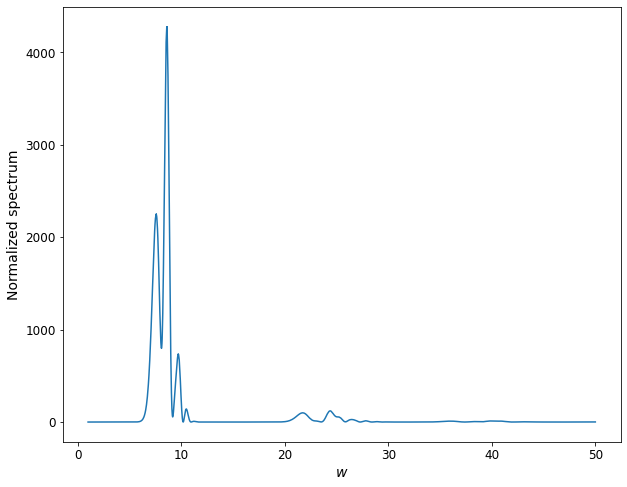

In [0]:
plt.figure(figsize=(10,8))
plt.plot(w, I, label='numerical')
plt.xlabel('$w$', fontsize=14)
plt.ylabel('Normalized spectrum', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [0]:
I, w = spec_I_w_many(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded, u0, gamma0, x0)

In [0]:
w_start_interp = 0
w_end_interp = 100

w_start = 1
w_end = 50

n_w = (w_end - w_start) * 2000

#f = open('timings_seq.txt', 'a+')

start = time.time()

I, w = spec_I_w_many(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded, u0, gamma0, x0)

I_sep, w_f = I_separate(w, I, w_start, w_end, n_w, w_start_interp, w_end_interp)

I, w_f = I_sum(w, I, w_start, w_end, n_w, w_start_interp, w_end_interp)

end = time.time() - start
print('First run: ', end)
#f.write('%d %.6f\n' %(n_electrons,end))

start = time.time()

I, w = spec_I_w_many(eta, a0, delta, tau, d_eta, t0, n_t_points, n_t_padded, u0, gamma0, x0)

I_sep, w_f = I_separate(w, I, w_start, w_end, n_w, w_start_interp, w_end_interp)

I, w_f = I_sum(w, I, w_start, w_end, n_w, w_start_interp, w_end_interp)

end = time.time() - start
print('Second run: ', end)
#f.write('%d %.6f\n' %(n_electrons,end))

#f.close()

First run:  6.280783176422119
Second run:  5.422114849090576


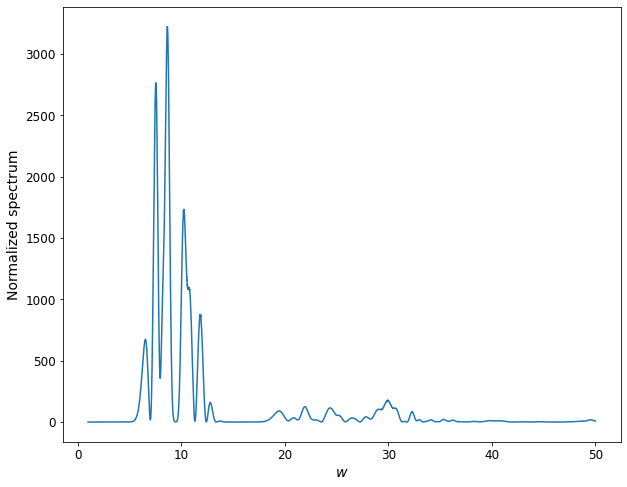

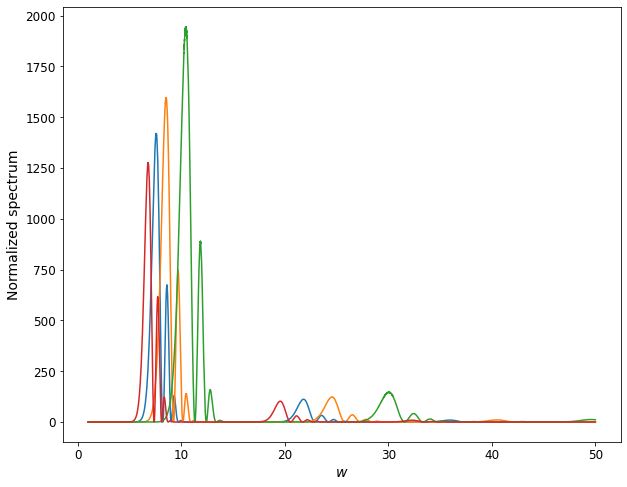

In [0]:
plt.figure(figsize=(10,8))
plt.plot(w_f, I, label='numerical')
plt.xlabel('$w$', fontsize=14)
plt.ylabel('Normalized spectrum', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10,8))
for i in range(n_electrons):
    plt.plot(w_f, I_sep[i], label='%d'%i)
plt.xlabel('$w$', fontsize=14)
plt.ylabel('Normalized spectrum', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()